In [ ]:
from aihwkit.utils.visualization import plot_device, plot_device_compact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import data_utils as du
from fit_piecewise import read_conductance_data, fit_piecewise_device, get_fit
import os
import sys
sys.path.append('/scratch/msc24h18/msc_project/scripts/aihwkit/')
sys.path.append('/scratch/msc24h18/msc_project/utils/src')

plt.style.use('ggplot')


SEED = 2024
PATH_DATASET = os.path.join("/scratch/msc24h18/msc_project/data", "DATASET")

In [2]:
DATA_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID294YR'

summary_files = du.get_summary_files(DATA_PATH)
print(f"Found {len(summary_files)} summary files")

Found 6 summary files


In [ ]:
summaries = [du.read_summary_file(f)[0] for f in summary_files]
_, device_configs, model_responses = zip(*[get_fit(f) for f in summary_files])
device_configs = list(device_configs)
model_responses = list(model_responses)

ID294YR - 11:05:17


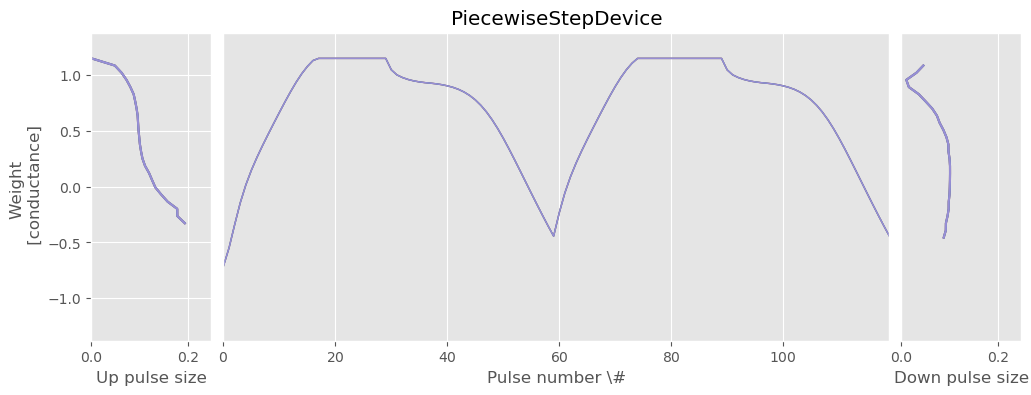

ID294YR - 11:10:52


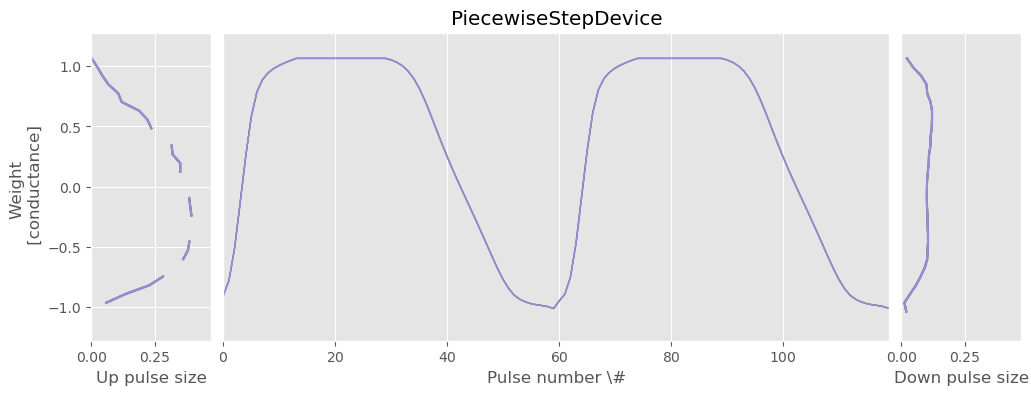

ID294YR - 11:12:21


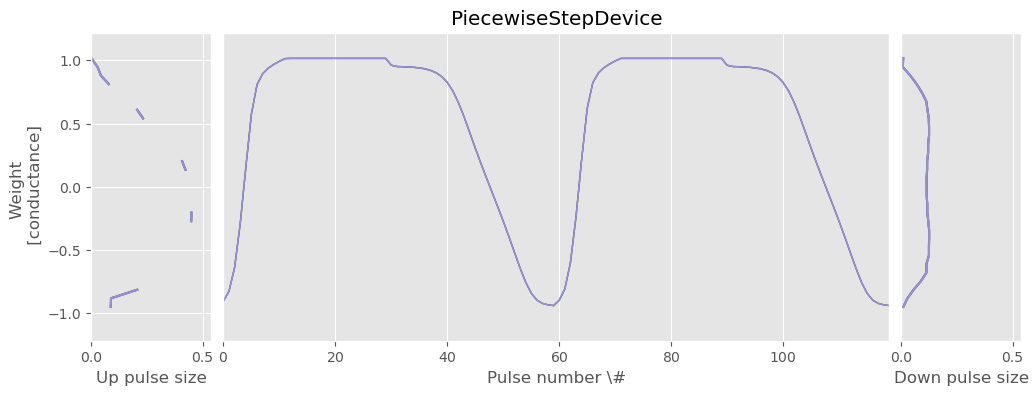

ID294YR - 11:13:50


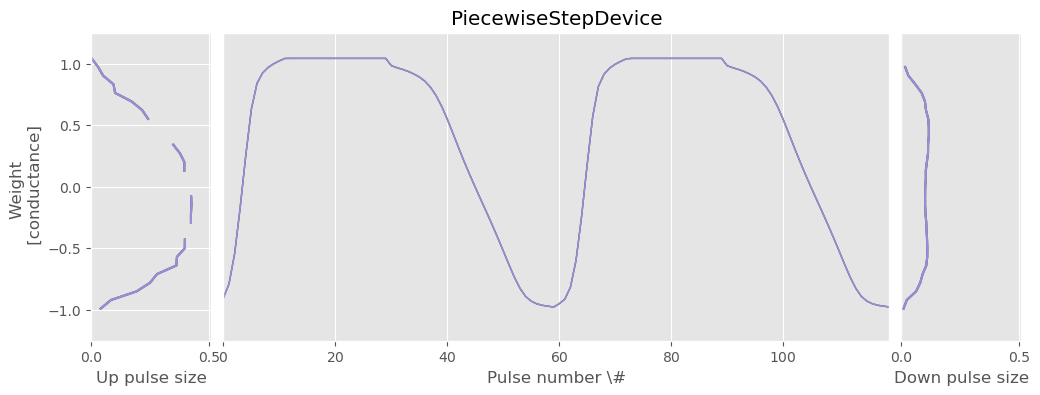

ID294YR - 11:19:27


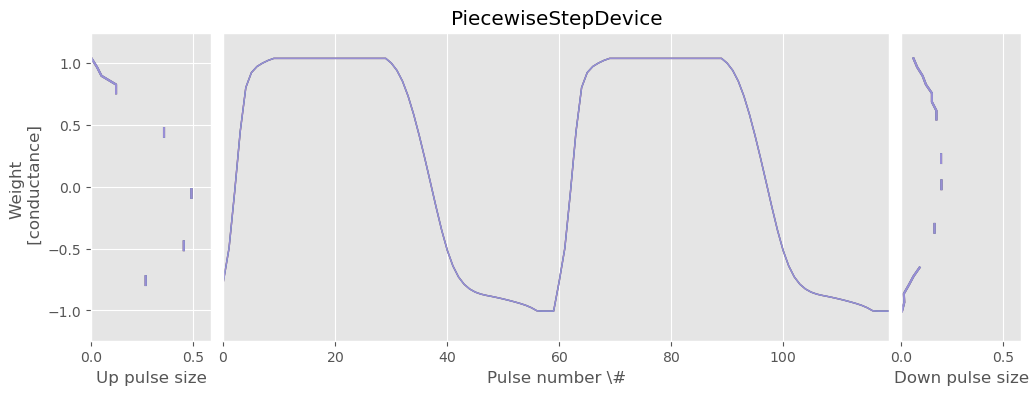

ID294YR - 11:21:56


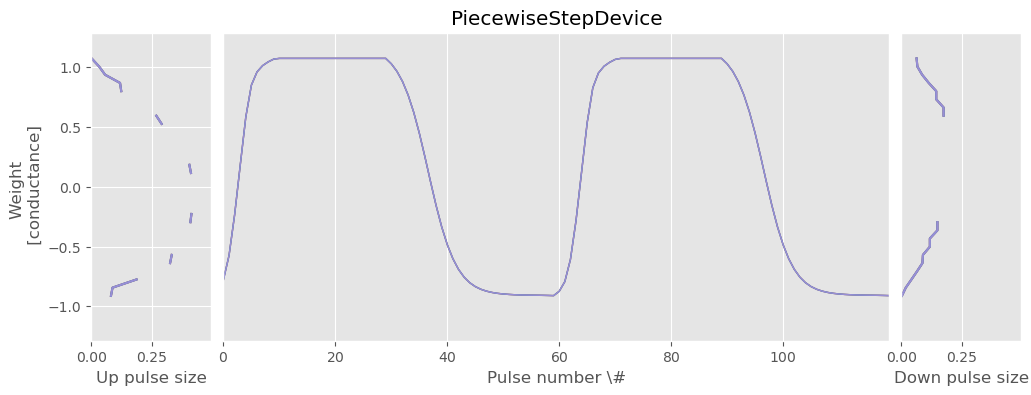

In [ ]:
for s, d in zip(summaries, device_configs):
    print(f"{s['device_id']} - {s['test_time']}")
    fig = plot_device_compact(d, n_steps=30)
    plt.show()

In [ ]:
import torch
from torch import Generator, argmax
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.nn.functional import nll_loss
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

from aihwkit.simulator.configs import build_config
from aihwkit.simulator.rpu_base import cuda
from aihwkit.nn.conversion import convert_to_analog_mapped
from aihwkit.optim import AnalogSGD, AnalogAdam

# Check device
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# DEVICE = torch.device("cpu")
print(f'Using device: {DEVICE}')

# train and test routines


def train(model, train_set, valid_set, optimizer, scheduler, epochs=3, save_weights=True, analog_weight_readout=False):
    """Train the network.

    Args:
        model (nn.Module): model to be trained.
        train_set (DataLoader): dataset of elements to use as input for training.
        valid_set (DataLoader): dataset of elements to use as input for validation.

    Returns:
        metrics (np.ndarray): array with the following values in the columns: epoch, train_loss, valid_loss, valid_accuracy.
    """
    metrics = np.zeros((epochs, 4))
    weights = [model.read_weights()] if analog_weight_readout else [model.get_weights()]

    classifier = nn.NLLLoss()

    for epoch_number in range(epochs):
        print(f"Epoch {epoch_number}:")
        total_loss = 0
        for i, (images, labels) in enumerate(train_set):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # Flatten MNIST images into a 784 vector.
            images = images.view(images.shape[0], -1)

            optimizer.zero_grad()
            # Add training Tensor to the model (input).
            output = model(images)
            loss = classifier(output, labels)

            # Run training (backward propagation).
            loss.backward()

            # Optimize weights.
            optimizer.step()

            total_loss += loss.item()

        print("\t- Training loss: {:.16f}".format(total_loss / len(train_set)))
        # save weights
        if save_weights:
            if analog_weight_readout:
                weights.append(model.read_weights())
            else:
                weights.append(model.get_weights())

        # Evaluate the model.
        predicted_ok = 0
        total_images = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in valid_set:
                # Predict image.
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                images = images.view(images.shape[0], -1)
                pred = model(images)
                loss = classifier(pred, labels)
                val_loss += loss.item()

                _, predicted = torch.max(pred.data, 1)
                total_images += labels.size(0)
                predicted_ok += (predicted == labels).sum().item()

            print(f"\t- Validation loss: {val_loss / len(valid_set):.16f}")
            print(f"\t- Validation accuracy: {predicted_ok / total_images:.4f}")

        # Decay learning rate if needed.
        scheduler.step()

        # Update metrics.
        metrics[epoch_number, 0] = epoch_number
        metrics[epoch_number, 1] = total_loss / len(train_set)  # train_loss
        metrics[epoch_number, 2] = val_loss / len(valid_set)  # valid_loss
        metrics[epoch_number, 3] = predicted_ok / total_images  # valid_accuracy

    if save_weights:
        return metrics, weights
    return metrics


def test(model, test_set):
    """Test trained network

    Args:
        model (nn.Model): Trained model to be evaluated
        test_set (DataLoader): Test set to perform the evaluation
    """
    # Setup counter of images predicted to 0.
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in test_set:
        # Predict image.
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        images = images.view(images.shape[0], -1)
        pred = model(images)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    print("\nNumber Of Images Tested = {}".format(total_images))
    print("Model Accuracy = {}".format(predicted_ok / total_images))


def get_dataset(batch_size=64, num_workers=23, split=[0.8, 0.2]):
    trainval_set = MNIST(PATH_DATASET, train=True, download=True, transform=ToTensor())
    test_set = MNIST(PATH_DATASET, train=False, download=True, transform=ToTensor())

    train_set, valid_set = random_split(trainval_set, split, generator=Generator().manual_seed(SEED))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, valid_loader, test_loader

Using device: cuda


In [ ]:
input_size = 784
# hidden_sizes = [256, 128]
hidden_sizes = [100]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0], True),
    nn.Sigmoid(),
    # nn.Linear(hidden_sizes[0], hidden_sizes[1], True),
    # nn.Sigmoid(),
    # nn.Linear(hidden_sizes[1], output_size, True),
    nn.Linear(hidden_sizes[0], output_size, True),
    nn.LogSoftmax(dim=1)
)

for d in device_configs:
    d.write_noise_std = 0
    d.dw_min_dtod = 0
    d.dw_min_std = 0
rpu_configs = [build_config('mp', device=device, construction_seed=SEED) for device in device_configs]
analog_models = [convert_to_analog_mapped(model, rpu_config=r) for r in rpu_configs]

if USE_CUDA:
    for m in analog_models:
        m.cuda()

In [ ]:
# Train the model
metrics_list = []
weights_list = []
for m in analog_models:
    train_loader, valid_loader, test_loader = get_dataset()

    optimizer = AnalogSGD(analog_models[0].parameters(), lr=0.5)
    optimizer.regroup_param_groups(model)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    metrics, weights = train(m,
                             train_loader,
                             valid_loader,
                             optimizer,
                             scheduler,
                             epochs=25,
                             save_weights=True,
                             analog_weight_readout=False)

    metrics_list.append(metrics)
    weights_list.append(weights)

Epoch 0:


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/scratch/msc24h18/.conda/envs/aihwkit_env/lib/python3.11/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/msc24h18/.conda/envs/aihwkit_env/lib/python3.11/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/msc24h18/.conda/envs/aihwkit_env/lib/python3.11/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/msc24h18/.conda/envs/aihwkit_env/lib/python3.11/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/scratch/msc24h18/.conda/envs/aihwkit_env/lib/python3.11/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
Traceback (most recent call last):
  File "

RuntimeError: DataLoader worker (pid(s) 1372645, 1372789) exited unexpectedly

In [ ]:
np.random.seed(SEED)


def plot_random_weights(weights, n_traces):
    keys = weights[0].keys()

    traces = np.zeros((n_traces * len(keys), len(weights)))

    for i, w in enumerate(weights):
        for j, k in enumerate(keys):
            shape = w[k][0].shape
            x_idx = np.random.randint(0, shape[0], n_traces)
            y_idx = np.random.randint(0, shape[1], n_traces)

            chosen_weights = [w[k][0][x, y].item() for x, y in zip(x_idx, y_idx)]
            traces[j*n_traces:(j+1)*n_traces, i] = chosen_weights

    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    # the first 2*n_traces traces are the input layer
    for i in range(2*n_traces):
        ax[0].plot(traces[i, :], alpha=0.8)

    # the next n_traces traces are the output layer
    for i in range(n_traces):
        ax[1].plot(traces[2*n_traces+i, :], alpha=0.8)

    ax[0].set(title='Input layer', ylabel='Weight', ylim=(-1, 1))
    ax[1].set(title='Output layer', xlabel='Epoch', ylabel='Weight', ylim=(-1, 1))

    plt.show()

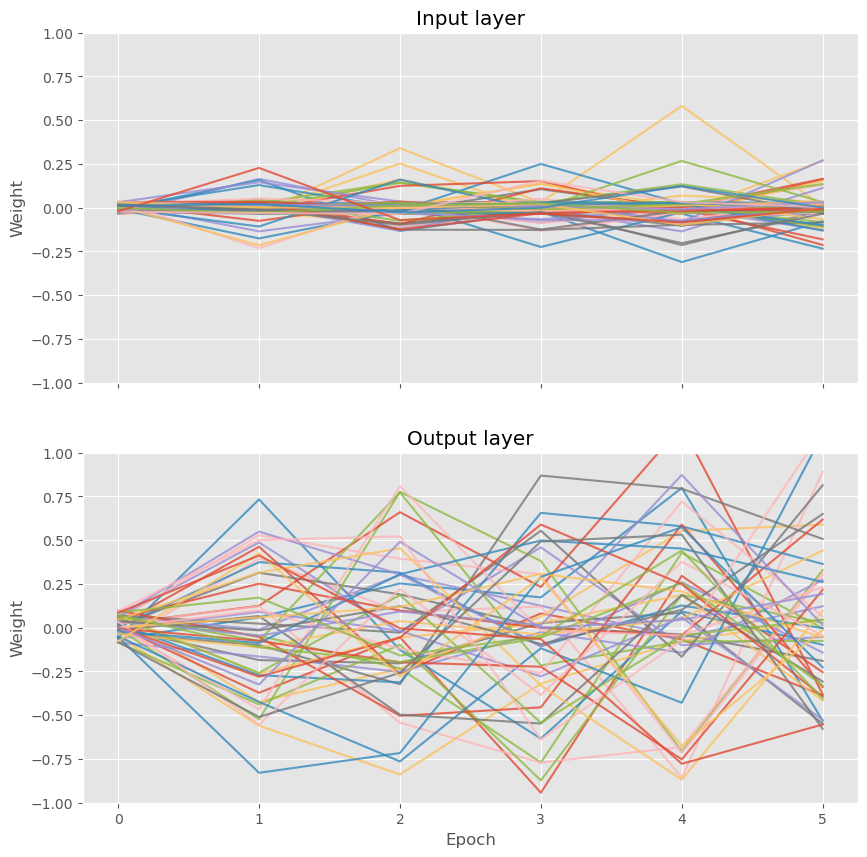

In [ ]:
n_traces = 50  # select the number of random weights to pick per (sub)layer
plot_random_weights(weights_list[0], n_traces)

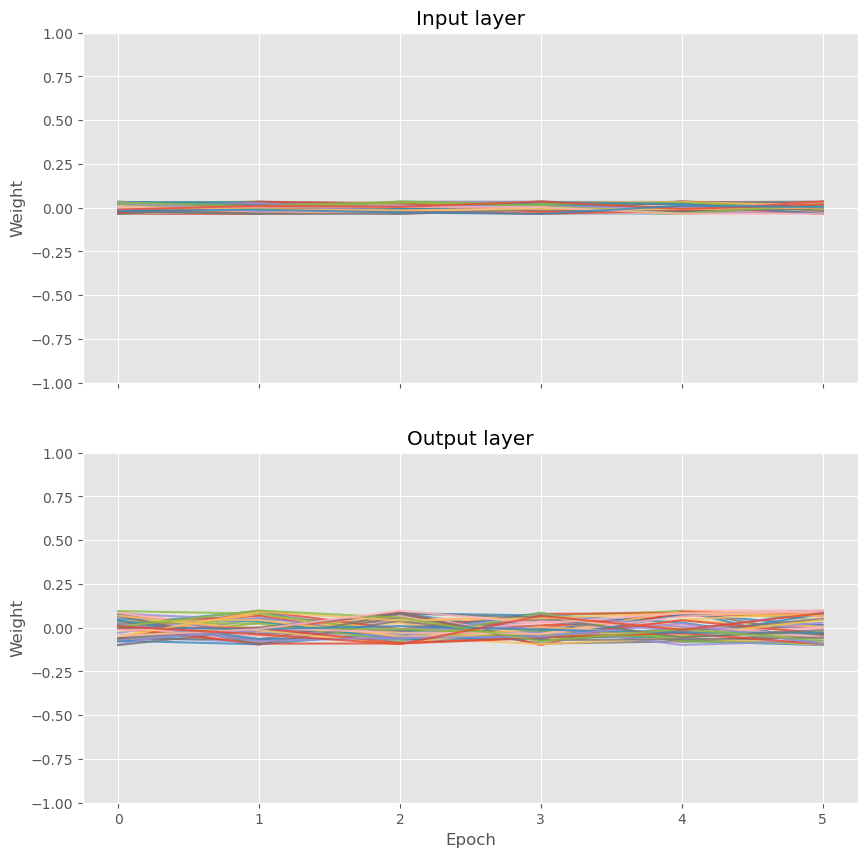

In [ ]:
plot_random_weights(weights_list[1], n_traces)